In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/spam-text-message-classification/SPAM text message 20170820 - Data.csv


doctovec的用法,embeding如何嵌入keras,lstm  
copy from :https://www.kaggle.com/khotijahs1/using-lstm-for-nlp-text-classification

## 一、数据清洗

In [3]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from keras.preprocessing.text import Tokenizer
tqdm.pandas(desc="progress-bar")
from gensim.models import Doc2Vec
from sklearn import utils
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
import gensim
from sklearn.linear_model import LogisticRegression
from gensim.models.doc2vec import TaggedDocument
import re
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
df = pd.read_csv('../input/spam-text-message-classification/SPAM text message 20170820 - Data.csv',delimiter=',',encoding='latin-1')
df = df[['Category','Message']]
df = df[pd.notnull(df['Message'])]
df.rename(columns = {'Message':'Message'}, inplace = True)
df.head()

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [6]:
df.shape

(5572, 2)

In [7]:
df['Message'][0]

'Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...'

In [8]:
df['Message'].apply(lambda x: len(x.split(' '))).sum()

87265

In [9]:
df['Message'].apply(lambda x: len(x.split(' '))).max()

171

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


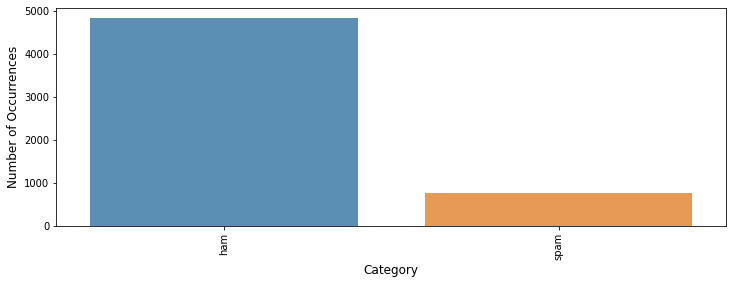

In [10]:
#正负样本
cnt_pro = df['Category'].value_counts()
plt.figure(figsize=(12,4))
sns.barplot(cnt_pro.index, cnt_pro.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Category', fontsize=12)
plt.xticks(rotation=90)
plt.show();

In [11]:
#数据清洗
from bs4 import BeautifulSoup
def cleanText(text):
    text = BeautifulSoup(text, "lxml").text
    text = re.sub(r'\|\|\|', r' ', text) 
    text = re.sub(r'http\S+', r'<URL>', text)
    text = text.lower()
    text = text.replace('x', '')
    return text
df['Message'] = df['Message'].apply(cleanText)

In [12]:
#转成wordtovec训练数据格式
import nltk
from nltk.corpus import stopwords
def tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text):
        for word in nltk.word_tokenize(sent):
            #if len(word) < 0:
            if len(word) <= 0:
                continue
            tokens.append(word.lower())
    return tokens
train_tagged = df.apply(
    lambda r: TaggedDocument(words=tokenize_text(r['Message']), tags=[r.Category]), axis=1)

In [13]:
# The maximum number of words to be used. (most frequent)
max_fatures = 500000

# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 50

#tokenizer = Tokenizer(num_words=max_fatures, split=' ')
tokenizer = Tokenizer(num_words=max_fatures, split=' ', filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df['Message'].values)
X = tokenizer.texts_to_sequences(df['Message'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (5572, 50)


In [14]:
train_tagged.values

array([TaggedDocument(words=['go', 'until', 'jurong', 'point', ',', 'crazy..', 'available', 'only', 'in', 'bugis', 'n', 'great', 'world', 'la', 'e', 'buffet', '...', 'cine', 'there', 'got', 'amore', 'wat', '...'], tags=['ham']),
       TaggedDocument(words=['ok', 'lar', '...', 'joking', 'wif', 'u', 'oni', '...'], tags=['ham']),
       TaggedDocument(words=['free', 'entry', 'in', '2', 'a', 'wkly', 'comp', 'to', 'win', 'fa', 'cup', 'final', 'tkts', '21st', 'may', '2005.', 'tet', 'fa', 'to', '87121', 'to', 'receive', 'entry', 'question', '(', 'std', 'tt', 'rate', ')', 't', '&', 'c', "'s", 'apply', '08452810075over18', "'s"], tags=['spam']),
       ...,
       TaggedDocument(words=['pity', ',', '*', 'was', 'in', 'mood', 'for', 'that', '.', 'so', '...', 'any', 'other', 'suggestions', '?'], tags=['ham']),
       TaggedDocument(words=['the', 'guy', 'did', 'some', 'bitching', 'but', 'i', 'acted', 'like', 'i', "'d", 'be', 'interested', 'in', 'buying', 'something', 'else', 'net', 'week', 'and', 

In [15]:
#训练模型
d2v_model = Doc2Vec(dm=1, dm_mean=1, vector_size=20, window=8, min_count=1, workers=1, alpha=0.065, min_alpha=0.065)
d2v_model.build_vocab([x for x in tqdm(train_tagged.values)])

100%|██████████| 5572/5572 [00:00<00:00, 1399608.45it/s]


In [16]:
%%time
for epoch in range(30):
    d2v_model.train(utils.shuffle([x for x in tqdm(train_tagged.values)]), total_examples=len(train_tagged.values), epochs=1)
    d2v_model.alpha -= 0.002
    d2v_model.min_alpha = d2v_model.alpha

100%|██████████| 5572/5572 [00:00<00:00, 1488861.69it/s]


CPU times: user 13.8 s, sys: 119 ms, total: 13.9 s
Wall time: 13.9 s


**Doc2Vec参数：**

size 是特征向量的纬度。

window 是要预测的词和文档中用来预测的上下文词之间的最大距离。

alpha 是初始化的学习速率，会随着训练过程线性下降。

seed 是随机数生成器。.需要注意的是，对于一个完全明确的重复运行（fully deterministically-reproducible run），你必须同时限制模型单线程工作以消除操作系统线程调度中的有序抖动。（在python3中，解释器启动的再现要求使用PYTHONHASHSEED环境变量来控制散列随机化）

min_count 忽略总频数小于此的所有的词。

max_vocab_size 在词汇累积的时候限制内存。如果有很多独特的词多于此，则将频率低的删去。每一千万词类大概需要1G的内存，设为None以不限制（默认）。

sample 高频词被随机地降低采样的阈值。默认为0（不降低采样），较为常用的事1e-5。

dm 定义了训练的算法。默认是dm=1,使用 ‘distributed memory’ (PV-DM)，否则 distributed bag of words (PV-DBOW)。

workers 使用多少现成来训练模型（越快的训练需要越多核的机器）。

iter 语料库的迭代次数。从Word2Vec中继承得到的默认是5，但在已经发布的‘Paragraph Vector’中，设为10或者20是很正常的。

hs 如果为1 (默认)，分层采样将被用于模型训练（否则设为0）。

negative 如果 > 0，将使用负采样，它的值决定干扰词的个数（通常为5-20）。

dm_mean 如果为0（默认），使用上下文词向量的和；如果为1，使用均值。（仅在dm被用在非拼接模型时使用）

dm_concat 如果为1，使用上下文词向量的拼接，默认是0。注意，拼接的结果是一个更大的模型，输入的大小不再是一个词向量（采样或算术结合），而是标签和上下文中所有词结合在一起的大小。

dm_tag_count 每个文件期望的文本标签数，在使用dm_concat模式时默认为1。

dbow_words 如果设为1，训练word-vectors (in skip-gram fashion) 的同时训练 DBOW doc-vector。默认是0 (仅训练doc-vectors时更快)。

In [18]:
word_index = tokenizer.word_index

In [19]:
word_index

{'i': 1,
 'to': 2,
 'you': 3,
 'a': 4,
 'the': 5,
 'u': 6,
 'and': 7,
 'in': 8,
 'is': 9,
 'me': 10,
 'my': 11,
 'for': 12,
 'your': 13,
 'it': 14,
 'of': 15,
 'call': 16,
 'have': 17,
 'on': 18,
 '2': 19,
 'that': 20,
 'now': 21,
 'are': 22,
 'so': 23,
 'but': 24,
 'not': 25,
 'or': 26,
 'do': 27,
 'can': 28,
 'at': 29,
 "i'm": 30,
 'ur': 31,
 'get': 32,
 'will': 33,
 'if': 34,
 'be': 35,
 'with': 36,
 'just': 37,
 'no': 38,
 'we': 39,
 'this': 40,
 '4': 41,
 'up': 42,
 'when': 43,
 'ok': 44,
 'free': 45,
 'go': 46,
 'how': 47,
 'from': 48,
 'all': 49,
 'out': 50,
 'what': 51,
 'know': 52,
 'like': 53,
 'good': 54,
 'then': 55,
 'got': 56,
 'come': 57,
 'was': 58,
 'its': 59,
 'am': 60,
 'time': 61,
 'day': 62,
 'only': 63,
 'love': 64,
 'there': 65,
 'send': 66,
 'he': 67,
 'want': 68,
 'tet': 69,
 'tt': 70,
 'as': 71,
 'one': 72,
 'going': 73,
 'by': 74,
 "i'll": 75,
 'need': 76,
 'home': 77,
 'about': 78,
 'r': 79,
 'lor': 80,
 'sorry': 81,
 'still': 82,
 'see': 83,
 'stop': 84,
 '

In [23]:
d2v_model.wv.key_to_index

{'.': 0,
 'i': 1,
 'to': 2,
 'you': 3,
 ',': 4,
 '?': 5,
 'a': 6,
 '!': 7,
 'the': 8,
 '...': 9,
 'u': 10,
 'and': 11,
 'is': 12,
 'in': 13,
 'me': 14,
 'my': 15,
 'it': 16,
 'for': 17,
 ':': 18,
 'your': 19,
 'of': 20,
 'have': 21,
 'call': 22,
 'that': 23,
 'do': 24,
 'on': 25,
 ')': 26,
 'are': 27,
 "'s": 28,
 'now': 29,
 '2': 30,
 'so': 31,
 'not': 32,
 'but': 33,
 'or': 34,
 'can': 35,
 'at': 36,
 'we': 37,
 "'m": 38,
 'ur': 39,
 'if': 40,
 'get': 41,
 'be': 42,
 'will': 43,
 'with': 44,
 'just': 45,
 "n't": 46,
 '>': 47,
 'no': 48,
 'this': 49,
 '<': 50,
 'up': 51,
 'how': 52,
 'when': 53,
 '#': 54,
 '&': 55,
 'what': 56,
 'from': 57,
 'go': 58,
 'free': 59,
 'all': 60,
 'out': 61,
 '4': 62,
 'know': 63,
 'got': 64,
 'like': 65,
 'was': 66,
 'good': 67,
 'ok': 68,
 'then': 69,
 "'ll": 70,
 '-': 71,
 'come': 72,
 'there': 73,
 'am': 74,
 'he': 75,
 'time': 76,
 'its': 77,
 'only': 78,
 'day': 79,
 'love': 80,
 'want': 81,
 'send': 82,
 'tet': 83,
 'as': 84,
 'one': 85,
 'tt': 86,


In [25]:
#词向量矩阵,注意对应关系！！
embedding_matrix = np.zeros((len(word_index) + 1, 20))
for word, i in word_index.items():
    if word in d2v_model.wv.key_to_index.keys():
        embedding_vector =  d2v_model.wv[word]
        if embedding_vector is not None:
            # words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector

In [26]:
embedding_matrix 

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.57661718, -0.4068436 ,  0.13996804, ...,  0.44582033,
        -1.56641781, -2.19487715],
       [ 0.05134909,  0.54185212,  0.32034889, ..., -1.26526308,
        -1.72701669, -1.52141416],
       ...,
       [ 0.39604884, -0.46405187,  0.02429809, ..., -0.23385215,
        -0.10229157,  0.39546338],
       [-0.06631708, -0.68689859, -0.63214523, ...,  0.22793831,
        -0.02189956, -0.14035219],
       [ 0.03611074,  0.30024698, -0.18846846, ...,  0.41678113,
        -0.0835176 , -0.25829342]])

In [27]:
#段落向量
sents = train_tagged.values
targets, regressors = zip(*[(doc.tags[0], d2v_model.infer_vector(doc.words, steps=20)) for doc in sents])

In [31]:
np.shape(regressors)

(5572, 20)

In [28]:
 d2v_model['good']

array([-2.470878  , -4.9283004 ,  1.2328985 ,  1.5308288 ,  0.41707933,
       -1.8315667 , -2.0374029 , -0.5837277 ,  1.5904692 ,  2.1860197 ,
       -0.7415845 ,  0.9282709 , -2.1264842 , -4.654714  , -1.5250632 ,
       -1.9240649 ,  5.541585  ,  1.4980023 ,  0.07813454,  3.2268908 ],
      dtype=float32)

In [29]:
d2v_model.infer_vector(['he' ,'is','a','good','men'], steps=20) 

array([ 0.00010658, -0.00619582,  0.00264878,  0.015077  ,  0.01492536,
        0.01527963,  0.00927993,  0.01519282, -0.00874072, -0.01046975,
       -0.01011565,  0.00667693, -0.0164205 , -0.00197354,  0.00917124,
        0.00151853, -0.02132446,  0.00188598,  0.01893524,  0.02252498],
      dtype=float32)

### 二、wordtovec lstm

In [32]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Embedding


# init layer
model = Sequential()

# emmbed word vectors
model.add(Embedding(len(word_index)+1,20,input_length=X.shape[1],trainable=False,weights=[embedding_matrix]))
model.add(LSTM(50,return_sequences=False))
model.add(Dense(2,activation="softmax"))

# output model skeleton
model.summary()
model.compile(optimizer="adam",loss="binary_crossentropy",metrics=['acc'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 50, 20)            178600    
_________________________________________________________________
lstm (LSTM)                  (None, 50)                14200     
_________________________________________________________________
dense (Dense)                (None, 2)                 102       
Total params: 192,902
Trainable params: 14,302
Non-trainable params: 178,600
_________________________________________________________________


In [33]:
(len(word_index)+1)*20

178600

Non-trainable params:(len(word_index)+1)*20

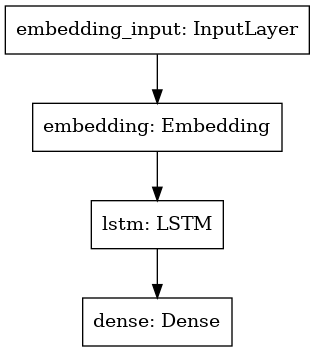

In [34]:
from keras.utils import plot_model
plot_model(model, to_file='model.png')

In [35]:
Y = pd.get_dummies(df['Category']).values
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.15, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(4736, 50) (4736, 2)
(836, 50) (836, 2)


In [36]:
batch_size = 32
history=model.fit(X_train, Y_train, epochs =50, batch_size=batch_size, verbose = 2)

Epoch 1/50
148/148 - 4s - loss: 0.2343 - acc: 0.9212
Epoch 2/50
148/148 - 3s - loss: 0.1029 - acc: 0.9679
Epoch 3/50
148/148 - 3s - loss: 0.0787 - acc: 0.9747
Epoch 4/50
148/148 - 3s - loss: 0.0633 - acc: 0.9806
Epoch 5/50
148/148 - 2s - loss: 0.0559 - acc: 0.9842
Epoch 6/50
148/148 - 2s - loss: 0.0492 - acc: 0.9861
Epoch 7/50
148/148 - 3s - loss: 0.0387 - acc: 0.9899
Epoch 8/50
148/148 - 3s - loss: 0.0382 - acc: 0.9890
Epoch 9/50
148/148 - 3s - loss: 0.0306 - acc: 0.9916
Epoch 10/50
148/148 - 3s - loss: 0.0234 - acc: 0.9916
Epoch 11/50
148/148 - 3s - loss: 0.0181 - acc: 0.9941
Epoch 12/50
148/148 - 3s - loss: 0.0147 - acc: 0.9960
Epoch 13/50
148/148 - 3s - loss: 0.0137 - acc: 0.9954
Epoch 14/50
148/148 - 3s - loss: 0.0090 - acc: 0.9968
Epoch 15/50
148/148 - 3s - loss: 0.0071 - acc: 0.9979
Epoch 16/50
148/148 - 3s - loss: 0.0056 - acc: 0.9985
Epoch 17/50
148/148 - 3s - loss: 0.0081 - acc: 0.9975
Epoch 18/50
148/148 - 3s - loss: 0.0045 - acc: 0.9985
Epoch 19/50
148/148 - 3s - loss: 0.00

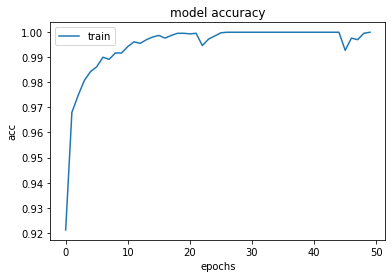

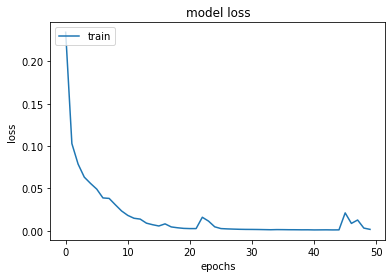

<Figure size 432x288 with 0 Axes>

In [37]:
plt.plot(history.history['acc'])
plt.title('model accuracy')
plt.ylabel('acc')
plt.xlabel('epochs')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.savefig('model_accuracy.png')

# summarize history for loss
plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.savefig('model_loss.png')

In [38]:
# evaluate the model
_, train_acc = model.evaluate(X_train, Y_train, verbose=2)
_, test_acc = model.evaluate(X_test, Y_test, verbose=2)
print('Train: %.3f, Test: %.4f' % (train_acc, test_acc))

148/148 - 2s - loss: 0.0013 - acc: 0.9998
27/27 - 1s - loss: 0.0680 - acc: 0.9880
Train: 1.000, Test: 0.9880


In [39]:
# predict probabilities for test set
yhat_probs = model.predict(X_test, verbose=0)
print(yhat_probs)
# predict crisp classes for test set
yhat_classes = model.predict_classes(X_test, verbose=0)
print(yhat_classes)
# reduce to 1d array
yhat_probs = yhat_probs[:, 0]
#yhat_classes = yhat_classes[:, 1

[[1.0000000e+00 1.6723917e-09]
 [9.9999976e-01 2.0554901e-07]
 [1.0000000e+00 8.5552134e-09]
 ...
 [1.0000000e+00 2.9915066e-12]
 [1.0000000e+00 7.8081031e-12]
 [1.0000000e+00 1.8283951e-09]]


/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 1 0 1 1
 1 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 1
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 1 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0
 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 1 1 0 0 0
 0 1 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0
 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 1 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 1 0 0 0 1 0 0 0
 1 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 0 0 0 1 0 0 0 

In [40]:
import numpy as np
rounded_labels=np.argmax(Y_test, axis=1)
rounded_labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0,

In [41]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(rounded_labels, yhat_classes)
cm

array([[727,   2],
       [  8,  99]])

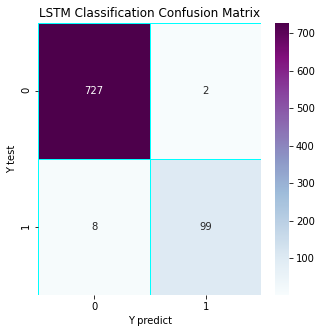

In [42]:
# The confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

lstm_val = confusion_matrix(rounded_labels, yhat_classes)
f, ax = plt.subplots(figsize=(5,5))
sns.heatmap(lstm_val, annot=True, linewidth=0.7, linecolor='cyan', fmt='g', ax=ax, cmap="BuPu")
plt.title('LSTM Classification Confusion Matrix')
plt.xlabel('Y predict')
plt.ylabel('Y test')
plt.show()

In [43]:
validation_size = 200

X_validate = X_test[-validation_size:]
Y_validate = Y_test[-validation_size:]
X_test = X_test[:-validation_size]
Y_test = Y_test[:-validation_size]
score,acc = model.evaluate(X_test, Y_test, verbose = 1, batch_size = batch_size)

print("score: %.2f" % (score))
print("acc: %.2f" % (acc))

20/20 [==============================] - 0s 9ms/step - loss: 0.0734 - acc: 0.9858
score: 0.07
acc: 0.99


In [44]:
message = ['Congratulations! you have won a $1,000 Walmart gift card. Go to http://bit.ly/123456 to claim now.']
seq = tokenizer.texts_to_sequences(message)

padded = pad_sequences(seq, maxlen=X.shape[1], dtype='int32', value=0)

pred = model.predict(padded)

labels = ['ham','spam']
print(pred, labels[np.argmax(pred)])

[[2.4839519e-08 1.0000000e+00]] spam


### 三、dv-lr

In [47]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score

X_train, X_test, y_train, y_test = train_test_split(np.array(regressors),np.array(targets), test_size = 0.15, random_state = 42)
logreg = LogisticRegression(n_jobs=1, C=1e5)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

print('Training accuracy %s' % accuracy_score(y_train,logreg.predict(X_train)))
print('Training F1 score: {}'.format(f1_score(y_train, logreg.predict(X_train), average='weighted')))
print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))

Training accuracy 0.8625422297297297
Training F1 score: 0.8167920665434063
Testing accuracy 0.8660287081339713
Testing F1 score: 0.826394698891115
